<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-первичный-анализ-данных" data-toc-modified-id="Загрузка-и-первичный-анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и первичный анализ данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Подготовка-текста" data-toc-modified-id="Подготовка-текста-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Подготовка текста</a></span></li><li><span><a href="#Подготовка-выборок-и-векторизация-текста" data-toc-modified-id="Подготовка-выборок-и-векторизация-текста-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Подготовка выборок и векторизация текста</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li></ul></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Классификация токсичных комментариев для "Викишоп".

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классификации комментариев на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**План по выполнению проекта:**

1. Загрузка и подготовка данных с помощью техники TF-IDF.
2. Обучение разных моделей, тестирование.
4. Вывод по проекту.


In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import vstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import re

In [3]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/vladimir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vladimir/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vladimir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Определение констант
SEED = 12345

## Подготовка данных

1. Загрузка и изучение данных;
2. Подготовка данных к обучению моделей.

### Загрузка и первичный анализ данных

In [5]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')

In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
df.duplicated().sum()

0

**Исследование баланса классов**

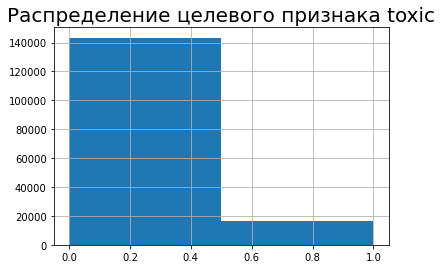

In [9]:
df['toxic'].hist(bins=2)
plt.title('Распределение целевого признака toxic', fontsize = 20)
plt.show();

In [10]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [11]:
print('Доля токсичных комментариев: ', 
      df[df['toxic'] == 1]['toxic'].count() / df[df['toxic'] == 0]['toxic'].count()
     )

Доля токсичных комментариев:  0.1131876717871444


Получается данные у нас не сбалансированны.

**Вывод**

1. Данные загружены и изучены. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.;
2. Пропусков и дубликатов в наборе данных нет;
3. Данные не сбалансированы. Токсичных коментариев примерно 11%;


### Подготовка данных

Подготовку данных произведём в следующей последовательности:
1. Подготовка текста;
2. Подготовка выборок;
3. Векторизация текста.

#### Подготовка текста

Применим к текстовым данным следующие инструменты подготовки текста:
1. Очистку от лишних символов;
2. Лематизацию;
3. Удаление стоп-слов.


Загрузим список английских стоп-слов и очистим от лишних символов.

In [12]:
%%time

wnl = WordNetLemmatizer()
stopwords = set(nltk_stopwords.words('english'))
# очистка с лематизацией
features = df['text'].apply(
    lambda x: ' '.join([wnl.lemmatize(re.sub(r'[^a-zA-Z]', ' ', i)
                                      .lower()) for i in x.split()])
)


CPU times: user 2min 15s, sys: 719 ms, total: 2min 15s
Wall time: 2min 16s


In [13]:
# До очистки
df['text'].head(10)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: text, dtype: object

In [14]:
# После очистки
features.head(10)

0    explanation why the edits made under my userna...
1    d aww  he match this background colour i m see...
2    hey man  i m really not trying to edit war  it...
3      more i can t make any real suggestion on imp...
4    you  sir  are my hero  any chance you remember...
5      congratulation from me a well  use the tool ...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word  nonsense  wa offensive to y...
9    alignment on this subject and which are contra...
Name: text, dtype: object

#### Подготовка выборок и векторизация текста

Разделим набор данных на выборки:
   - Тренировочную - 80%;
   - Валидационную - 10%;
   - Тестовую      - 10%.
   
После разделения данных, обучим векторизатор на тренировочной выборке, затем векторизируем валидационную и тестовую выборки. 

Затем создадим счетчик TF-IDF, передадим в него английские стоп-слова, будем также искать биграммы, ограничим максимальное количество признаков 50000, ограничим минимальное вхождение *n-gram* в текст двумя.


In [15]:
target = df['toxic']

In [16]:
%%time
# Создаём выборки
# так как целевой признак несбалансированы применим параметр  stratify = target

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2, 
                                                                              random_state=SEED,
                                                                              stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5, 
                                                                            random_state=SEED,
                                                                            stratify=target_valid)
# Векторизация текста
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, stop_words=stopwords)

features_train_vect = vectorizer.fit_transform(features_train)
features_valid_vect = vectorizer.transform(features_valid)
features_test_vect = vectorizer.transform(features_test)

# проверим размеры выборок
pd.DataFrame(data=[features_train_vect.shape, target_train.shape,
                   features_valid_vect.shape, target_valid.shape,
                   features_test_vect.shape,  target_test.shape
                  ],
             index=['features_train', 'target_train', 
                    'features_valid', 'target_valid', 
                    'features_test',  'target_test'],
             columns=['Строк', 'Колонок']
            )

CPU times: user 47.5 s, sys: 1.26 s, total: 48.8 s
Wall time: 48.8 s


,Строк,Колонок
features_train,127656,50000.0
target_train,127656,NaN
features_valid,15957,50000.0
target_valid,15957,NaN
features_test,15958,50000.0
target_test,15958,NaN


Данные подготовлены к обучению моделей.

## Обучение

Обучим несколько моделей с подбором гиперпараметров:
- Логистическую регрессию;
- Классификатор на основе решающего дерева;
- Случайный лес.

Для исключения дублирования кода создадим две функции:
- Функция `get_f1_valid` принимает модель и выборки, возвращает значение метрики F1;
- Функция `get_f1_cv` приниает модель параметры и выборки, возвращает лучшие параметры модели и лучший F1.

In [17]:
def get_f1_valid(model, X, y, X_test, y_test):
    """ Принимаем модель,
        возвращаем f1 
    """
    model.fit(X, y)
    predictions = model.predict(X_test)
     
    return round(f1_score(y_test, predictions), 3)

In [18]:
def get_f1_cv(model, 
              parametrs, 
              X=vstack((features_train_vect, features_valid_vect)), 
              y=pd.concat([target_train, target_valid])):
    """ Принимаем модель,
        возвращаем f1 
    """
    validation_set_indexes = [-1]*features_train_vect.shape[0] + [0]*features_valid_vect.shape[0]
    ps = PredefinedSplit(test_fold=validation_set_indexes)
    
    rs = RandomizedSearchCV(model, 
                            parametrs, 
                            scoring='f1', 
                            cv=ps,
                            random_state = SEED,
                            n_jobs=-1
                           )
    rs.fit(X, y)
    
    return round(rs.best_score_, 3), rs.best_params_

#### Логистическая регрессия

In [19]:
%%time
get_f1_valid(LogisticRegression(max_iter=2000, random_state=SEED), 
             X=features_train_vect, 
             y=target_train, 
             X_test=features_valid_vect, 
             y_test=target_valid
            )

CPU times: user 48 s, sys: 1.9 s, total: 49.9 s
Wall time: 14.2 s


0.735

Логистическая регрессия с параметрами по умолчанию показала F1=0.735

Теперь попробуем подобрать лучшие параметры

In [20]:
%%time
# Подбор коэфициента регуляризации
get_f1_cv(LogisticRegression(max_iter=2000, random_state=SEED),
          {'C':[2,3,4,5,7,10,15,20,40,50]}
         )

CPU times: user 1min 18s, sys: 3.94 s, total: 1min 22s
Wall time: 2min 8s


(0.787, {'C': 10})

In [21]:
%%time
# Модель с подобранными гиперпараметрами
get_f1_valid(LogisticRegression(max_iter=2000, C=10, random_state=SEED), 
             X=features_train_vect, 
             y=target_train, 
             X_test=features_valid_vect, 
             y_test=target_valid
            )

CPU times: user 1min 34s, sys: 4.19 s, total: 1min 38s
Wall time: 26.7 s


0.787

Логистическая регрессия после подбора коэфицента регуляризации достигла F1=0.787

**Вывод:** Логистическая регрессия с регуляризацией успешно справляется с поставленной задачей

#### Решающее дерево

In [22]:
%%time
get_f1_valid(DecisionTreeClassifier(max_depth=10, random_state=SEED), 
             X=features_train_vect, 
             y=target_train, 
             X_test=features_valid_vect, 
             y_test=target_valid
            )

CPU times: user 13.1 s, sys: 59.7 ms, total: 13.2 s
Wall time: 12.8 s


0.589

In [23]:
%%time
# Подбор максимальной глубины дерева
get_f1_cv(DecisionTreeClassifier(random_state=SEED),
          {'max_depth': range(2,50)}
         )

CPU times: user 1min 8s, sys: 108 ms, total: 1min 8s
Wall time: 4min 22s


(0.698, {'max_depth': 42})

In [24]:
%%time
# Модель с подобранными гиперпараметрами
get_f1_valid(DecisionTreeClassifier(max_depth=42, random_state=SEED), 
             X=features_train_vect, 
             y=target_train, 
             X_test=features_valid_vect, 
             y_test=target_valid
            )

CPU times: user 1min 3s, sys: 22.7 ms, total: 1min 3s
Wall time: 1min 3s


0.698

**Вывод:** С помощью решающего дерева не удаётся добиться заданного качества классификации

### Случайный лес

Преобразуем функцию get_f1_cv в функцию get_forest_f1_cv специально для случайного леса

In [25]:
def get_forest_f1_cv(model, 
              parametrs, 
              X=vstack((features_train_vect, features_valid_vect)), 
              y=pd.concat([target_train, target_valid])):
    """ Принимаем модель,
        возвращаем f1 
    """
    validation_set_indexes = [-1]*features_train_vect.shape[0] + [0]*features_valid_vect.shape[0]
    ps = PredefinedSplit(test_fold=validation_set_indexes)
    
    rs = GridSearchCV(model, 
                      parametrs, 
                      scoring='f1', 
                      cv=ps,
                      n_jobs=-1
                     )
    rs.fit(X, y)
    
    return round(rs.best_score_, 3), rs.best_params_

In [26]:
%%time
# Подбор максимальной глубины дерева и количества деревьев
forest_params = {'n_estimators':range(50,111,30),
                'max_depth': range(30,51,10),
}

get_forest_f1_cv(RandomForestClassifier(random_state=SEED),
                 forest_params
                )

CPU times: user 40.1 s, sys: 140 ms, total: 40.2 s
Wall time: 4min 55s


(0.274, {'max_depth': 50, 'n_estimators': 50})

**Вывод:** Модель случайный лес совсем не подошла для этой задачи.

### Тестирование

Протестируем лучшую модель на тестовой выборке.

In [27]:
%%time
get_f1_valid(LogisticRegression(max_iter=2000, C=10, random_state=SEED),
             X=vstack((features_train_vect, features_valid_vect)), 
             y=pd.concat([target_train, target_valid]),
             X_test=features_test_vect,
             y_test=target_test
            )

CPU times: user 1min 35s, sys: 3.96 s, total: 1min 39s
Wall time: 29.1 s


0.767

**Вывод**:
Модель Логистическая регрессия и на тестовой выборке показала приемлемое качество. 

## Вывод

В проекте был применен подход к преобразованию текстовых данных векторизация TF-IDF. 

Были обучены и оценены модели логистическая регрессия, решающее дерево и случайный лес.

По качеству и скорости обучения лучше всех показала Логистическая регрессия с коэфициентом *С=10* и *F1=0.767*. Она единственная из рассмотренных моделей достигла заданного заказчиком метрики качества *F1* = 0.75
